In [15]:
from scipy import signal
from scipy.integrate import simps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from data_utils import (
    load_data_from_dir,
)

from dataframe.csv_utils import (
    load_data_from_csv,
    get_filtered_data,
)

from feature_extraction import (
    Feature,
    EEG_BANDS,
)

from features.constants import (
    MARKER_METADATA
)
from biomarkers import (
    ALL_MARKERS
)

### Constant

In [16]:
from constants import SUEJECT_BATCHES, SORTED_BLOCK_NAMES, ALL_EEG_BANDS, AUDIO_BLOCKS


# All constants
DIR_NAME = "../CleandDataV2/2031"
BLOCK_NAME = "audio_hvla"
CHANNEL = 0
EPOCH = 0
BAND = Feature.DELTA
SUBJECTS_LIST = SUEJECT_BATCHES[2]

In [17]:
import ipywidgets as widgets

MARKER = widgets.Dropdown(
    options=ALL_MARKERS,
    value=ALL_MARKERS[0],
    description='Marker:',
    disabled=False,
)
MARKER

Dropdown(description='Marker:', options=('BP', 'ECG', 'EEG', 'EGG', 'EMG', 'EOG', 'GSR', 'Resp', 'TREV', 'beha…

### Load raw data

In [144]:
subj_to_data = {}
data_dir = '../CleandDataV2/'
for subj in ['2028', '2040']:
    dir_name = data_dir + str(subj)
    all_data = load_data_from_dir(dir_name)
    subj_to_data[subj] = all_data


Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2040 data...


### Load features from csv

In [ ]:
dir_name = "eeg_features2"
result = load_data_from_csv(dir_name)

In [ ]:
subjects = result['Subject'].unique()

all_blocks = []
for b in SORTED_BLOCK_NAMES:
    all_blocks.extend([b] * 13)


result["condition"] = all_blocks * len(subjects)
mask = result["condition"].isin(AUDIO_BLOCKS)
audio_only = result[mask]

### Plot eeg topography averaged trials

In [ ]:
import mne
from biomarkers import (
    EEG_CHANEL_NAMES,
    EEG_NUM_CHANNELS,
    EEG_MONTAGES,
    BEHAVIOR_LIST,
)

def plot_eeg_topomap(data, xlables, axes, num_epochs, legend_title, times):
    for i in range(len(xlables)):
        axes[i].set_xlabel(xlables[i], fontsize=25)
        axes[i].xaxis.set_label_position("bottom")

    sampling_freq = 512  # in Hertz
    info = mne.create_info(
        ch_names=EEG_CHANEL_NAMES,
        sfreq=sampling_freq,
        ch_types=["eeg"] * EEG_NUM_CHANNELS,
    )
    info.set_montage(EEG_MONTAGES)

    evoked_array = mne.EvokedArray(
        data,
        info,
        tmin=1,
        nave=num_epochs,
        comment="simulated",
    )
    if len(times) > 0:
        efig = evoked_array.plot_topomap(
            axes=axes,
            times=times,
            time_format="",
            ch_type="eeg",
            scalings=1,
            show=False,
        )
    else:
        efig = evoked_array.plot_topomap(
            axes=axes, time_format="", ch_type="eeg", scalings=1, show=False
        )

    axes[-1].set_title(legend_title, fontsize=25)
    axes[-1].tick_params(labelsize=15)
    return axes

In [ ]:
for subj in SUBJECTS_LIST :
    tmp = audio_only[audio_only["Subject"].isin([subj])]
    all_feature_array = tmp.drop(["Subject", "Valence", "Arousal", "Attention"], axis=1)

    fig, axes = plt.subplots(
            6,
            5,
            figsize=(35, 20),
            gridspec_kw={"width_ratios": [3, 3, 3, 3, 1]},
        )
    all_bands = ALL_EEG_BANDS
    xlables = list(pd.unique(all_feature_array.condition))

    for idx in range(len(all_bands)):
        band = all_bands[idx]
        data = all_feature_array.groupby('condition').mean().filter(regex=f".*{band}$")
        data = np.swapaxes(data.to_numpy(), 0, -1)
        axes[idx,:] = plot_eeg_topomap(data, xlables, axes[idx,:], 13, band, [])

    fig.suptitle(f"{subj} {MARKER} data averaged over trials", fontsize=35)
    filename = f"results/topomap/eeg_spectral_topography_{subj}.png"
    plt.savefig(filename)

### Plot eeg topography over time

In [ ]:
all_blocks_name = AUDIO_BLOCKS

for subj in SUBJECTS_LIST:
    all_data = subj_to_data[subj]

    fig, axes = plt.subplots(
        4,
        7,
        figsize=(35, 20),
        gridspec_kw={"width_ratios": [3, 3, 3, 3, 3, 3, 1]},
    )

    for idx in range(len(all_blocks_name)):
        b = all_blocks_name[idx]
        average_eeg_data = np.mean(all_data[b].get_all_data()[MARKER], axis=2)
        xlables = ["4s", "8s", "12s", "16s", "20s", "24s"]
        axes[idx, :] = plot_eeg_topomap(
            average_eeg_data, xlables, axes[idx, :], 13, b, [4, 8, 12, 16, 20, 24]
        )

    fig.suptitle(f"{subj} EEG raw data averaged over trials", fontsize=35)
    filename = f"results/{subj}_eeg_raw_topography.png"
    plt.savefig(filename)

## Time Series

In [19]:
marker = MARKER.value

num_epochs = 13

def get_channel_feature_dropdown(oneblock_data, marker: str):
    channels = oneblock_data.get_chanlocs(marker)
    options = [(channels[idx], idx) for idx in range(len(channels))]
    sf = oneblock_data.marker_to_data[marker]["srate"].item()[0][0]
    print(options, sf)
    return widgets.Dropdown(
        options=options,
        value=0,
        description="Feature:",
        disabled=False,
    )

def resample(data, original_freq: int, target_freq: int):
    period = "{}N".format(int(1e9 / original_freq))
    index = pd.date_range(start=0, periods=len(data), freq=period)
    # Create a DataFrame for the orignal hz series
    df = pd.DataFrame(data, index=index)

    period = "{}N".format(int(1e9 / target_freq))
    return df.resample(period).mean().to_numpy()


def configure_ax(ax, epoch, y_label):
    ax.set_title(
        f"Trial {epoch+1}",
        fontdict={"fontsize": 15, "fontweight": 20, "color": "blue"},
    )
    ax.set_xlabel("Time (seconds)", fontsize=15, weight=20)
    ax.yaxis.set_tick_params(labelsize=15)
    if epoch == 0:
        ax.set_ylabel(
            y_label,
            fontsize=30,
            color="red",
        )
    return ax


oneblock_data = all_data[BLOCK_NAME]

### Plot time series in audio blocks

In [66]:
marker = 'ECG'
feature = get_channel_feature_dropdown(oneblock_data, marker)
feature

[('data', 0)] 500


Dropdown(description='Feature:', options=(('data', 0),), value=0)

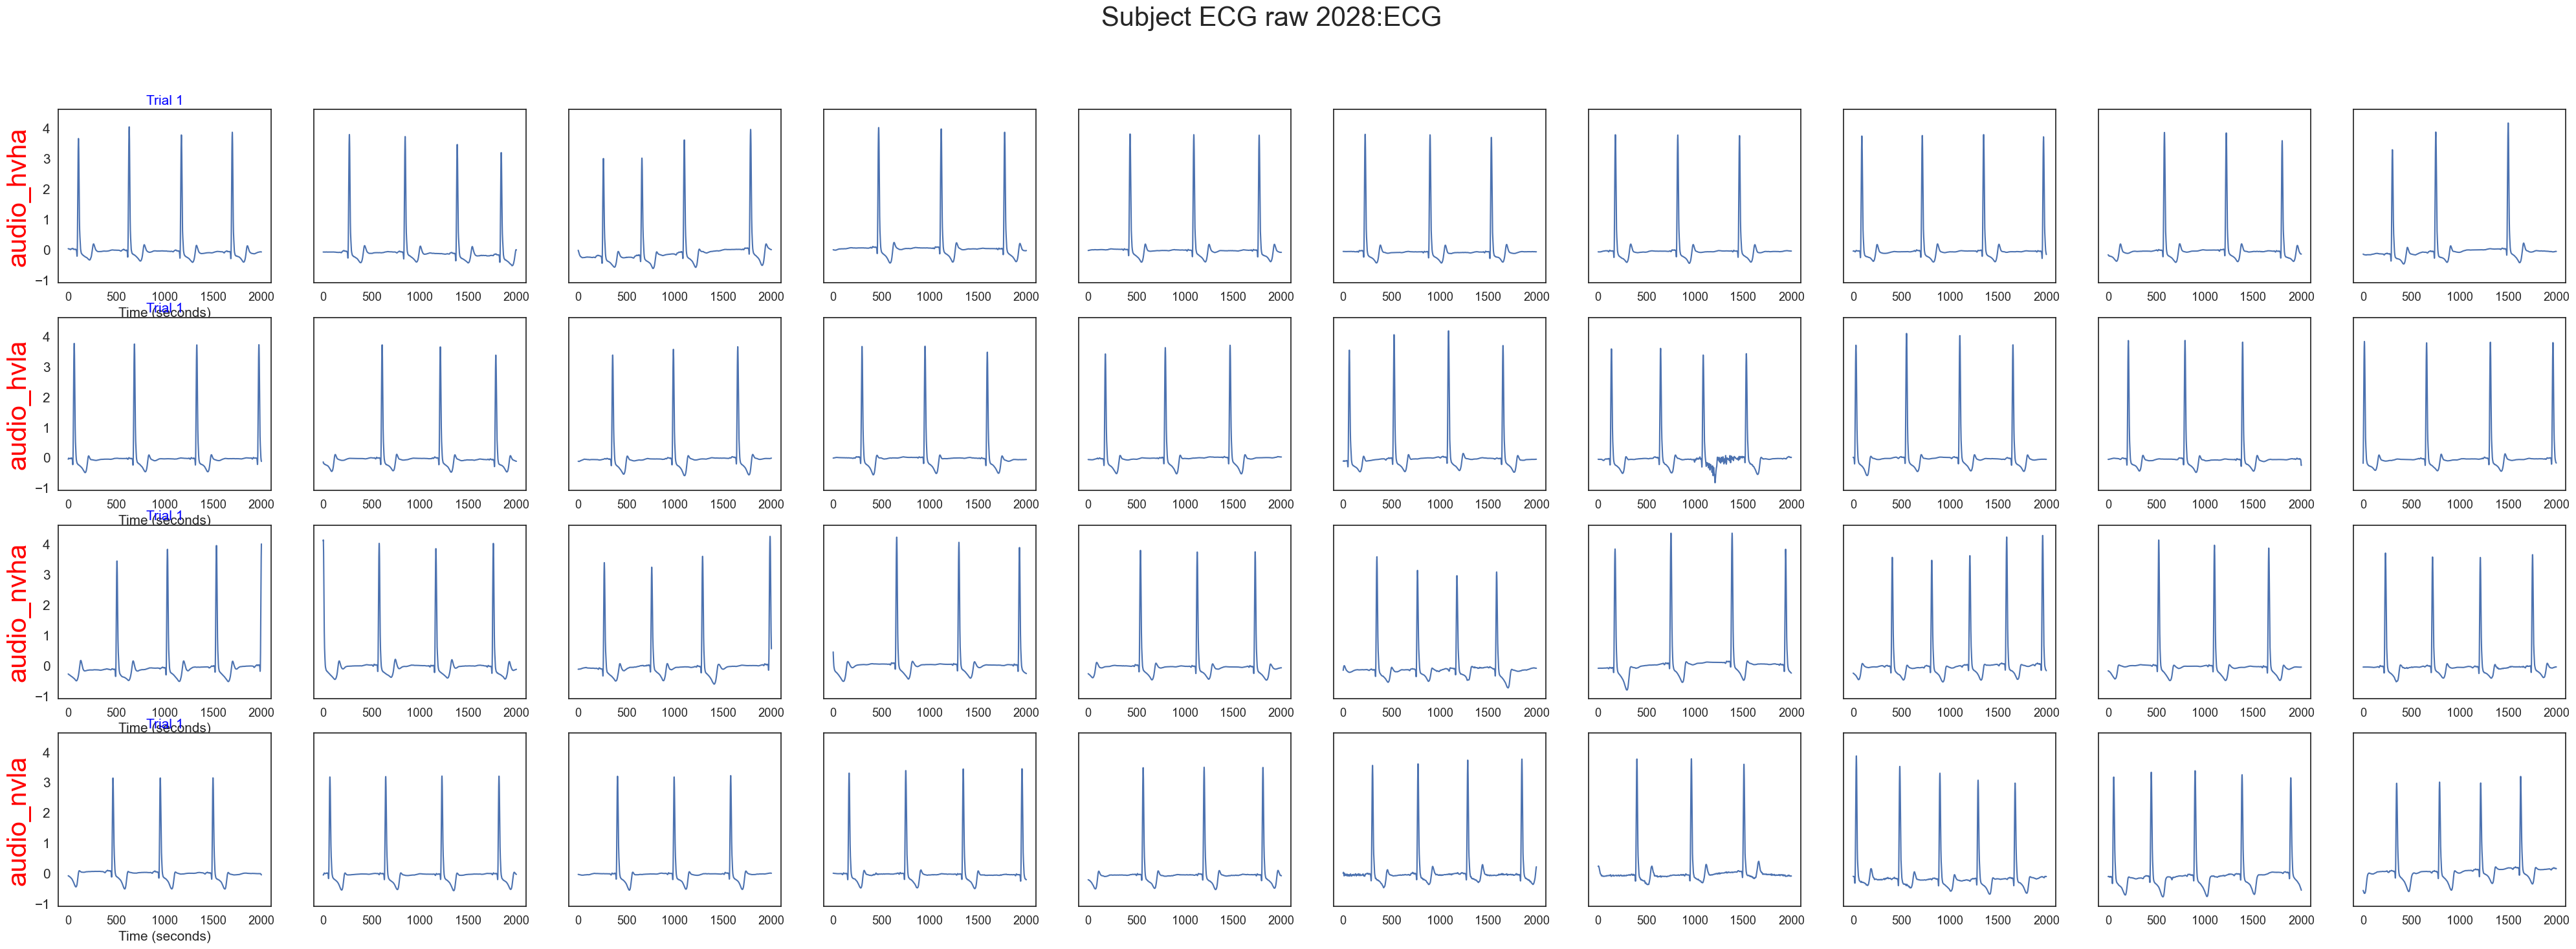

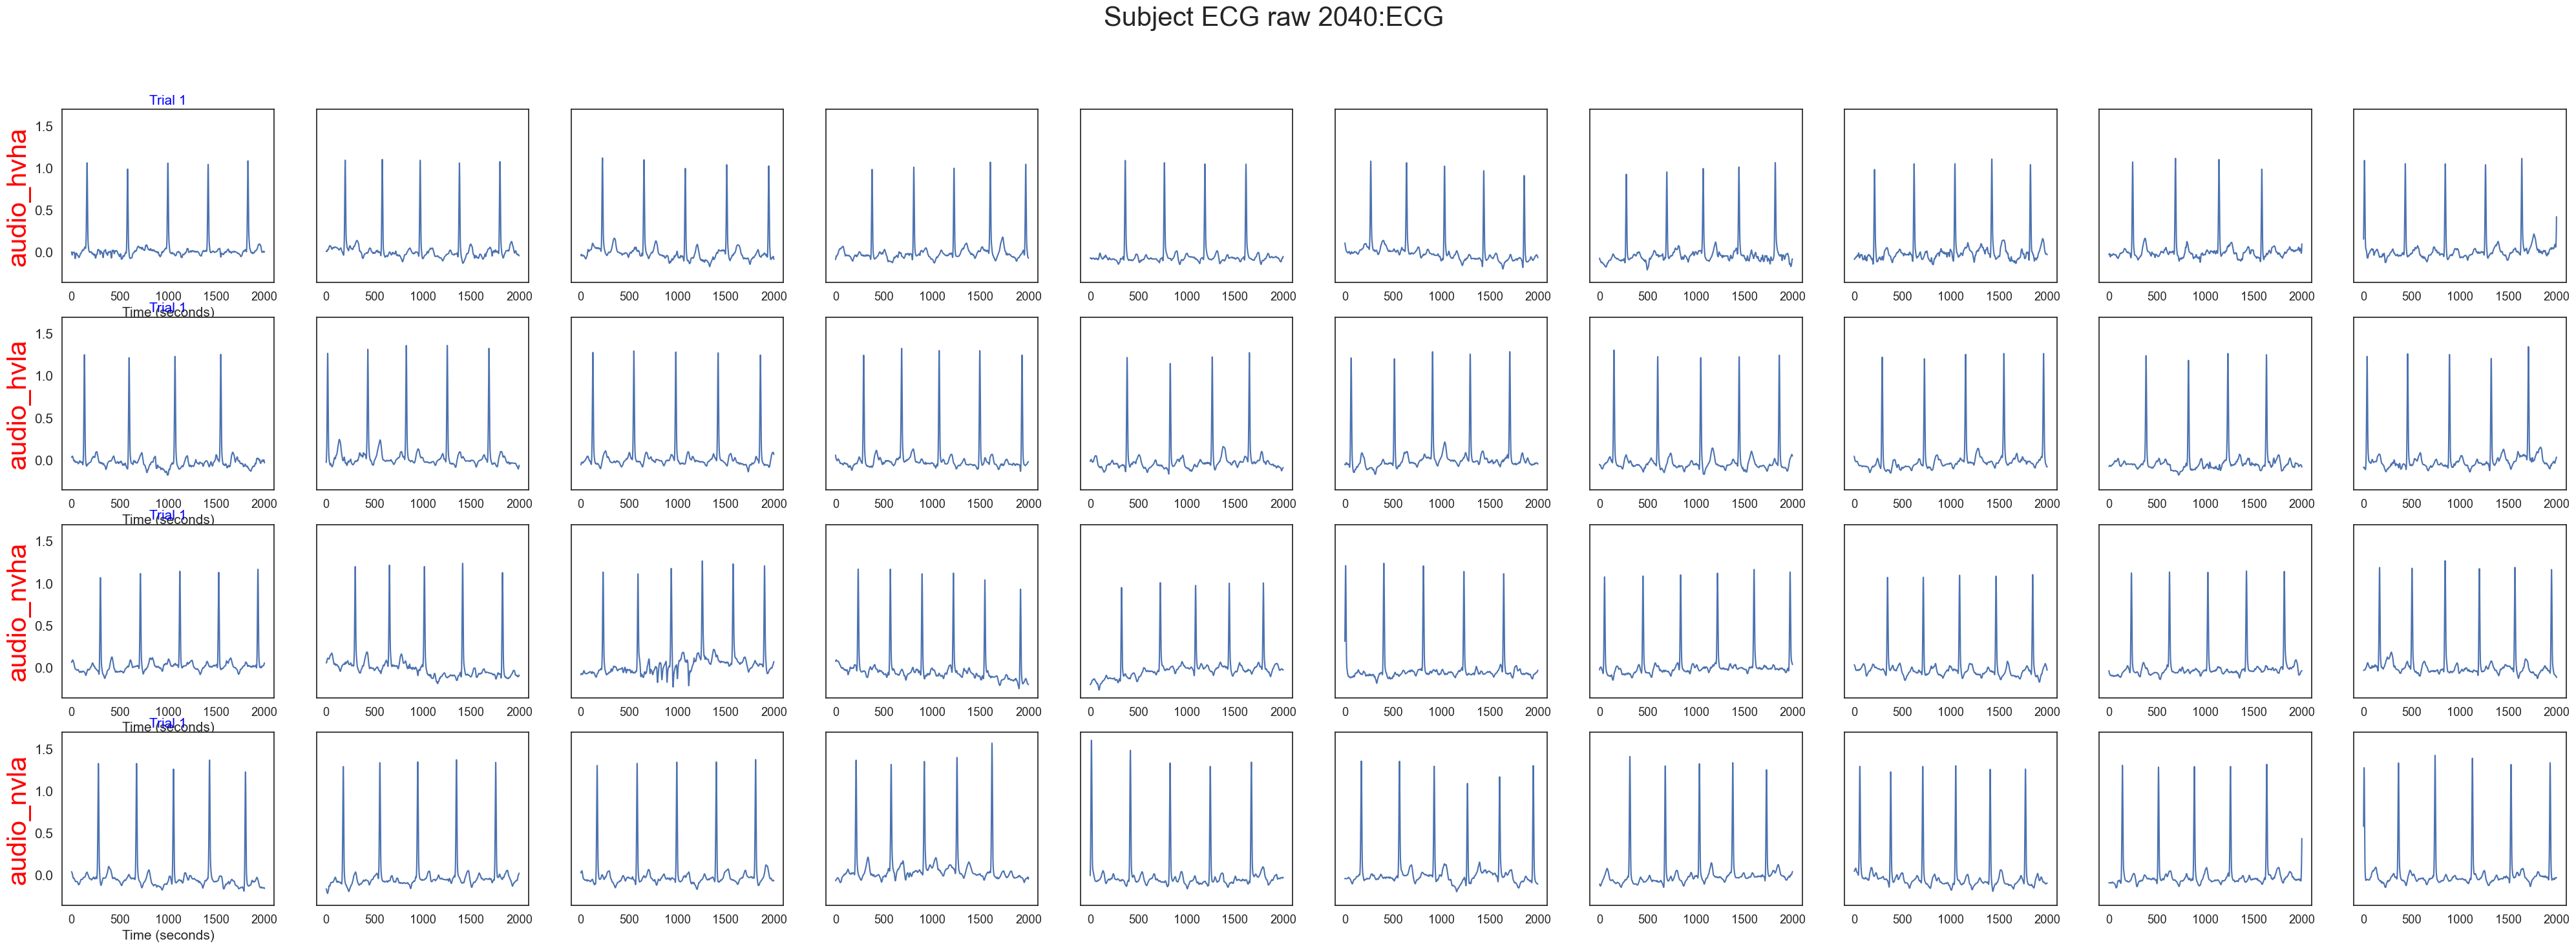

In [145]:
def _get_block_sliced_data_by_marker(subject_data, blocks, marker, second_per_slice):
    from resample.resample import (
        slice_data_by_seconds,
    )

    block_to_features = {}
    for b in blocks:
        block_data = subject_data[b]
        srate =  block_data.get_srate(marker)
        sliced_data = slice_data_by_seconds(block_data.get_all_data()[marker], srate, second_per_slice)[:,0,:]
        #psd_data = slice_data_by_seconds(block_data.marker_to_data['ECG']['avgHR'].item(), srate, 4)[:,0,:]
        block_to_features[b] = sliced_data
    return block_to_features  

def _global_mean_field_power(data):
    data = np.array(data) # (4000)
    data_mean_across_channels = np.mean(data) # (1)
    p_sum = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        p_sum[i] = (data[i]-data_mean_across_channels)**2
    
    return np.sqrt(p_sum)

#features.shape

channels = oneblock_data.get_chanlocs(marker)
num_trial = 2
second_per_slice = 4

num_slices = int(num_trial*((24/second_per_slice)-1)) # 5 slices per trial
for subj, subject_data in subj_to_data.items():
    from features.psd import welch_bandpower
    block_to_features = _get_block_sliced_data_by_marker(subject_data, AUDIO_BLOCKS, marker, second_per_slice)
    
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_slices,
        figsize=(num_slices * 5, len(AUDIO_BLOCKS) * 4),
        sharey=True,
        sharex=False,
    )
    idx = 0
    for block, features in block_to_features.items():
        configure_ax(axes.flat[idx], 0, block)
        for i in range(num_slices):
            #psd = _global_mean_field_power(features[i])
            sns.lineplot(features[i], ax=axes.flat[idx])
            # freqs, psd = welch_bandpower(features[i], 500, None, 2)
            # axes.flat[idx].plot(freqs, psd, color="k")
            # axes.flat[idx].set_xlim(0, 50)
            idx += 1

    fig.suptitle(f"Subject ECG raw {subj}:{marker}", fontsize=30)

### Plot ECG RR

In [91]:
# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return (similarity > threshold).nonzero()[0], similarity

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

#### Frequency domain

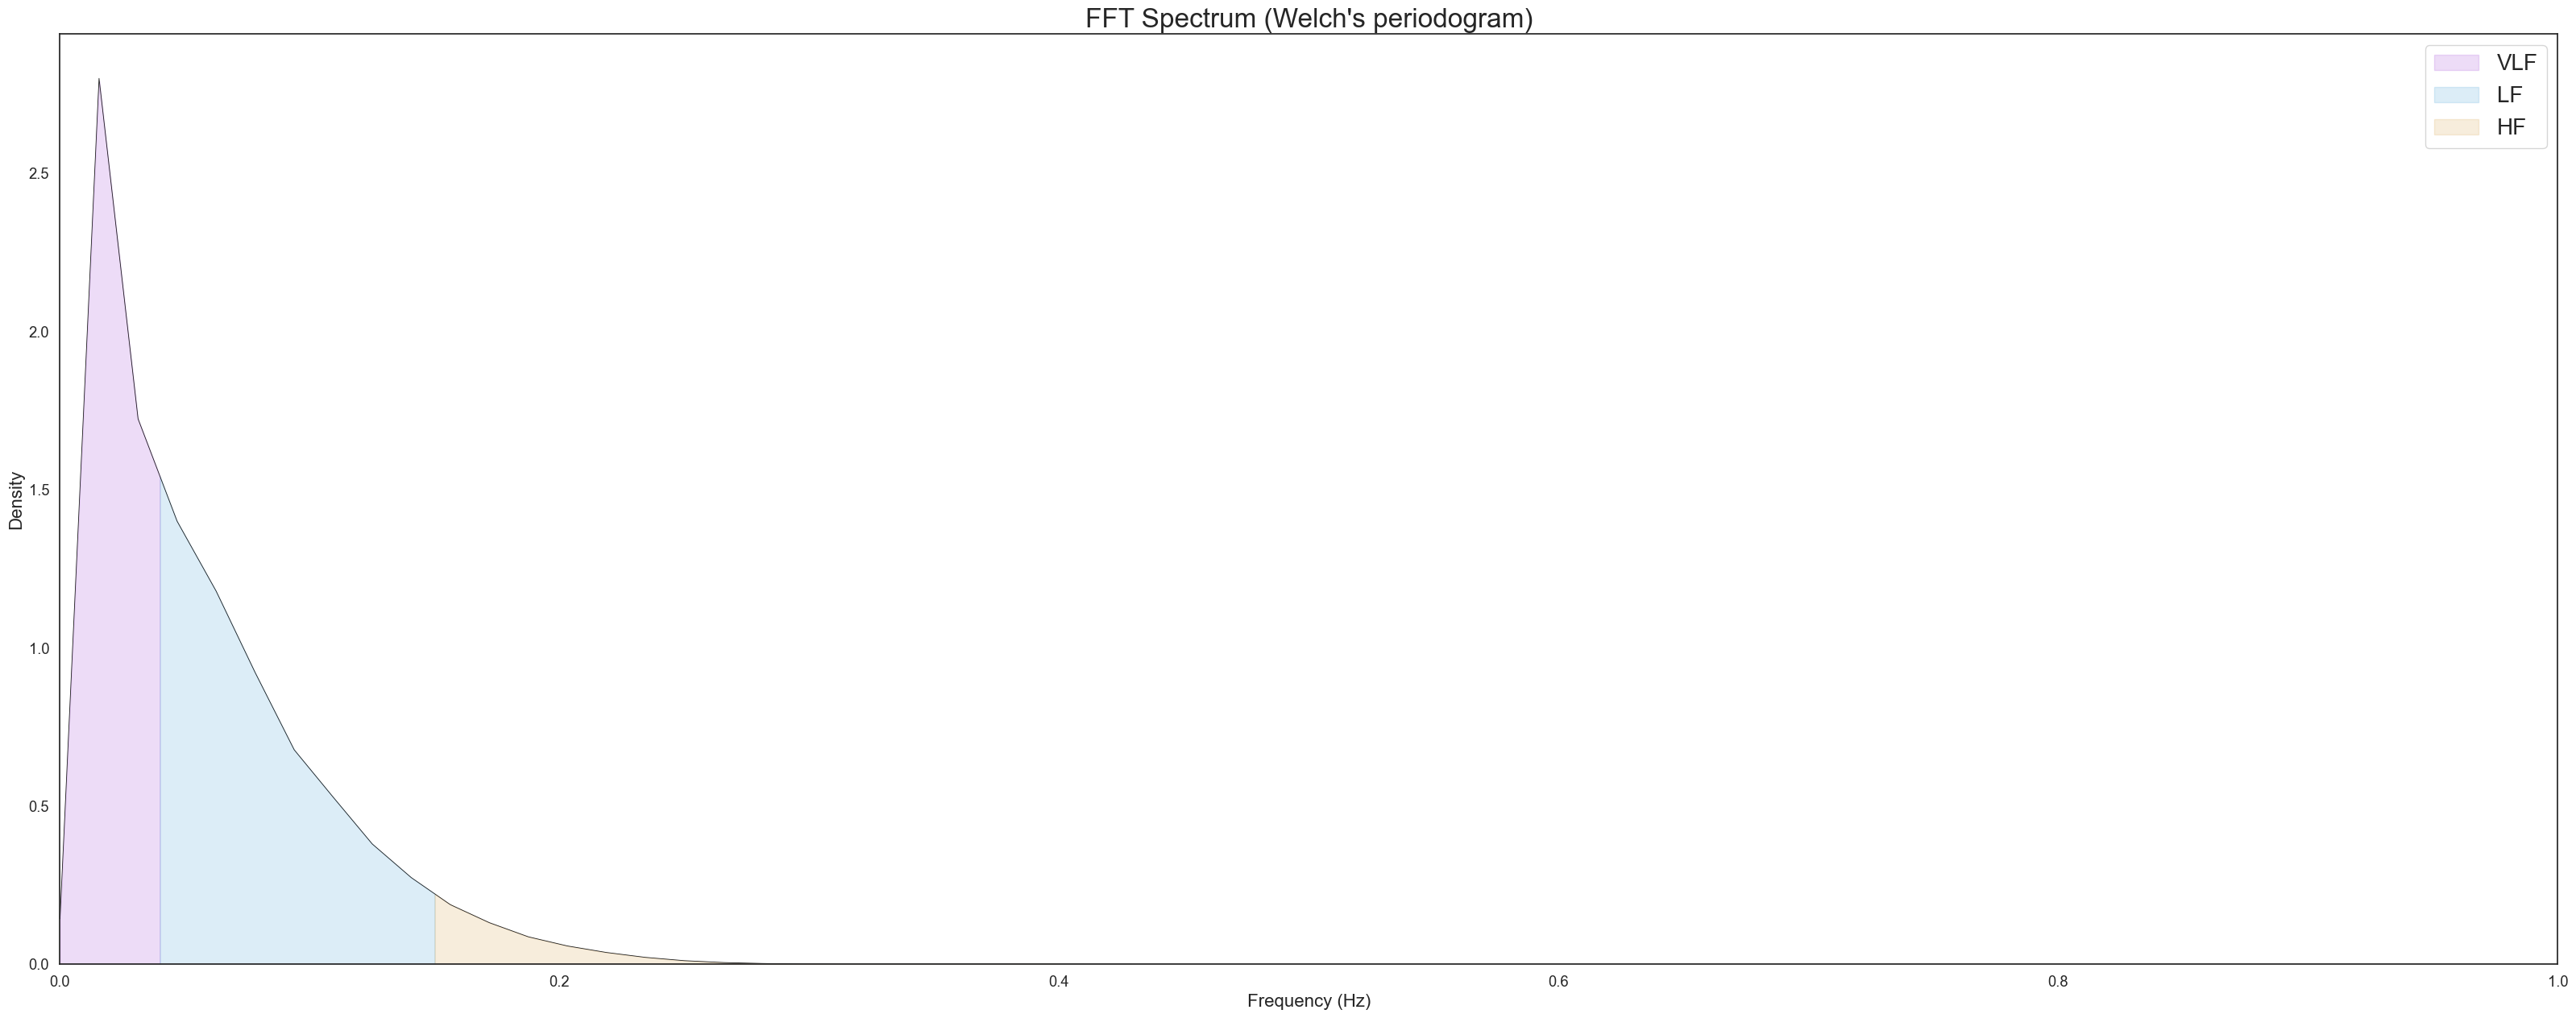

In [132]:
plt.figure(figsize=(40, 15))

fxx, pxx = signal.welch(features[0], 4)
plt.plot(fxx, pxx, color="k", linewidth=0.6)
plt.title("FFT Spectrum (Welch's periodogram)", fontsize=24)

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=20)

#### Time domain

Text(0, 0.5, 'Similarity (normalized)')

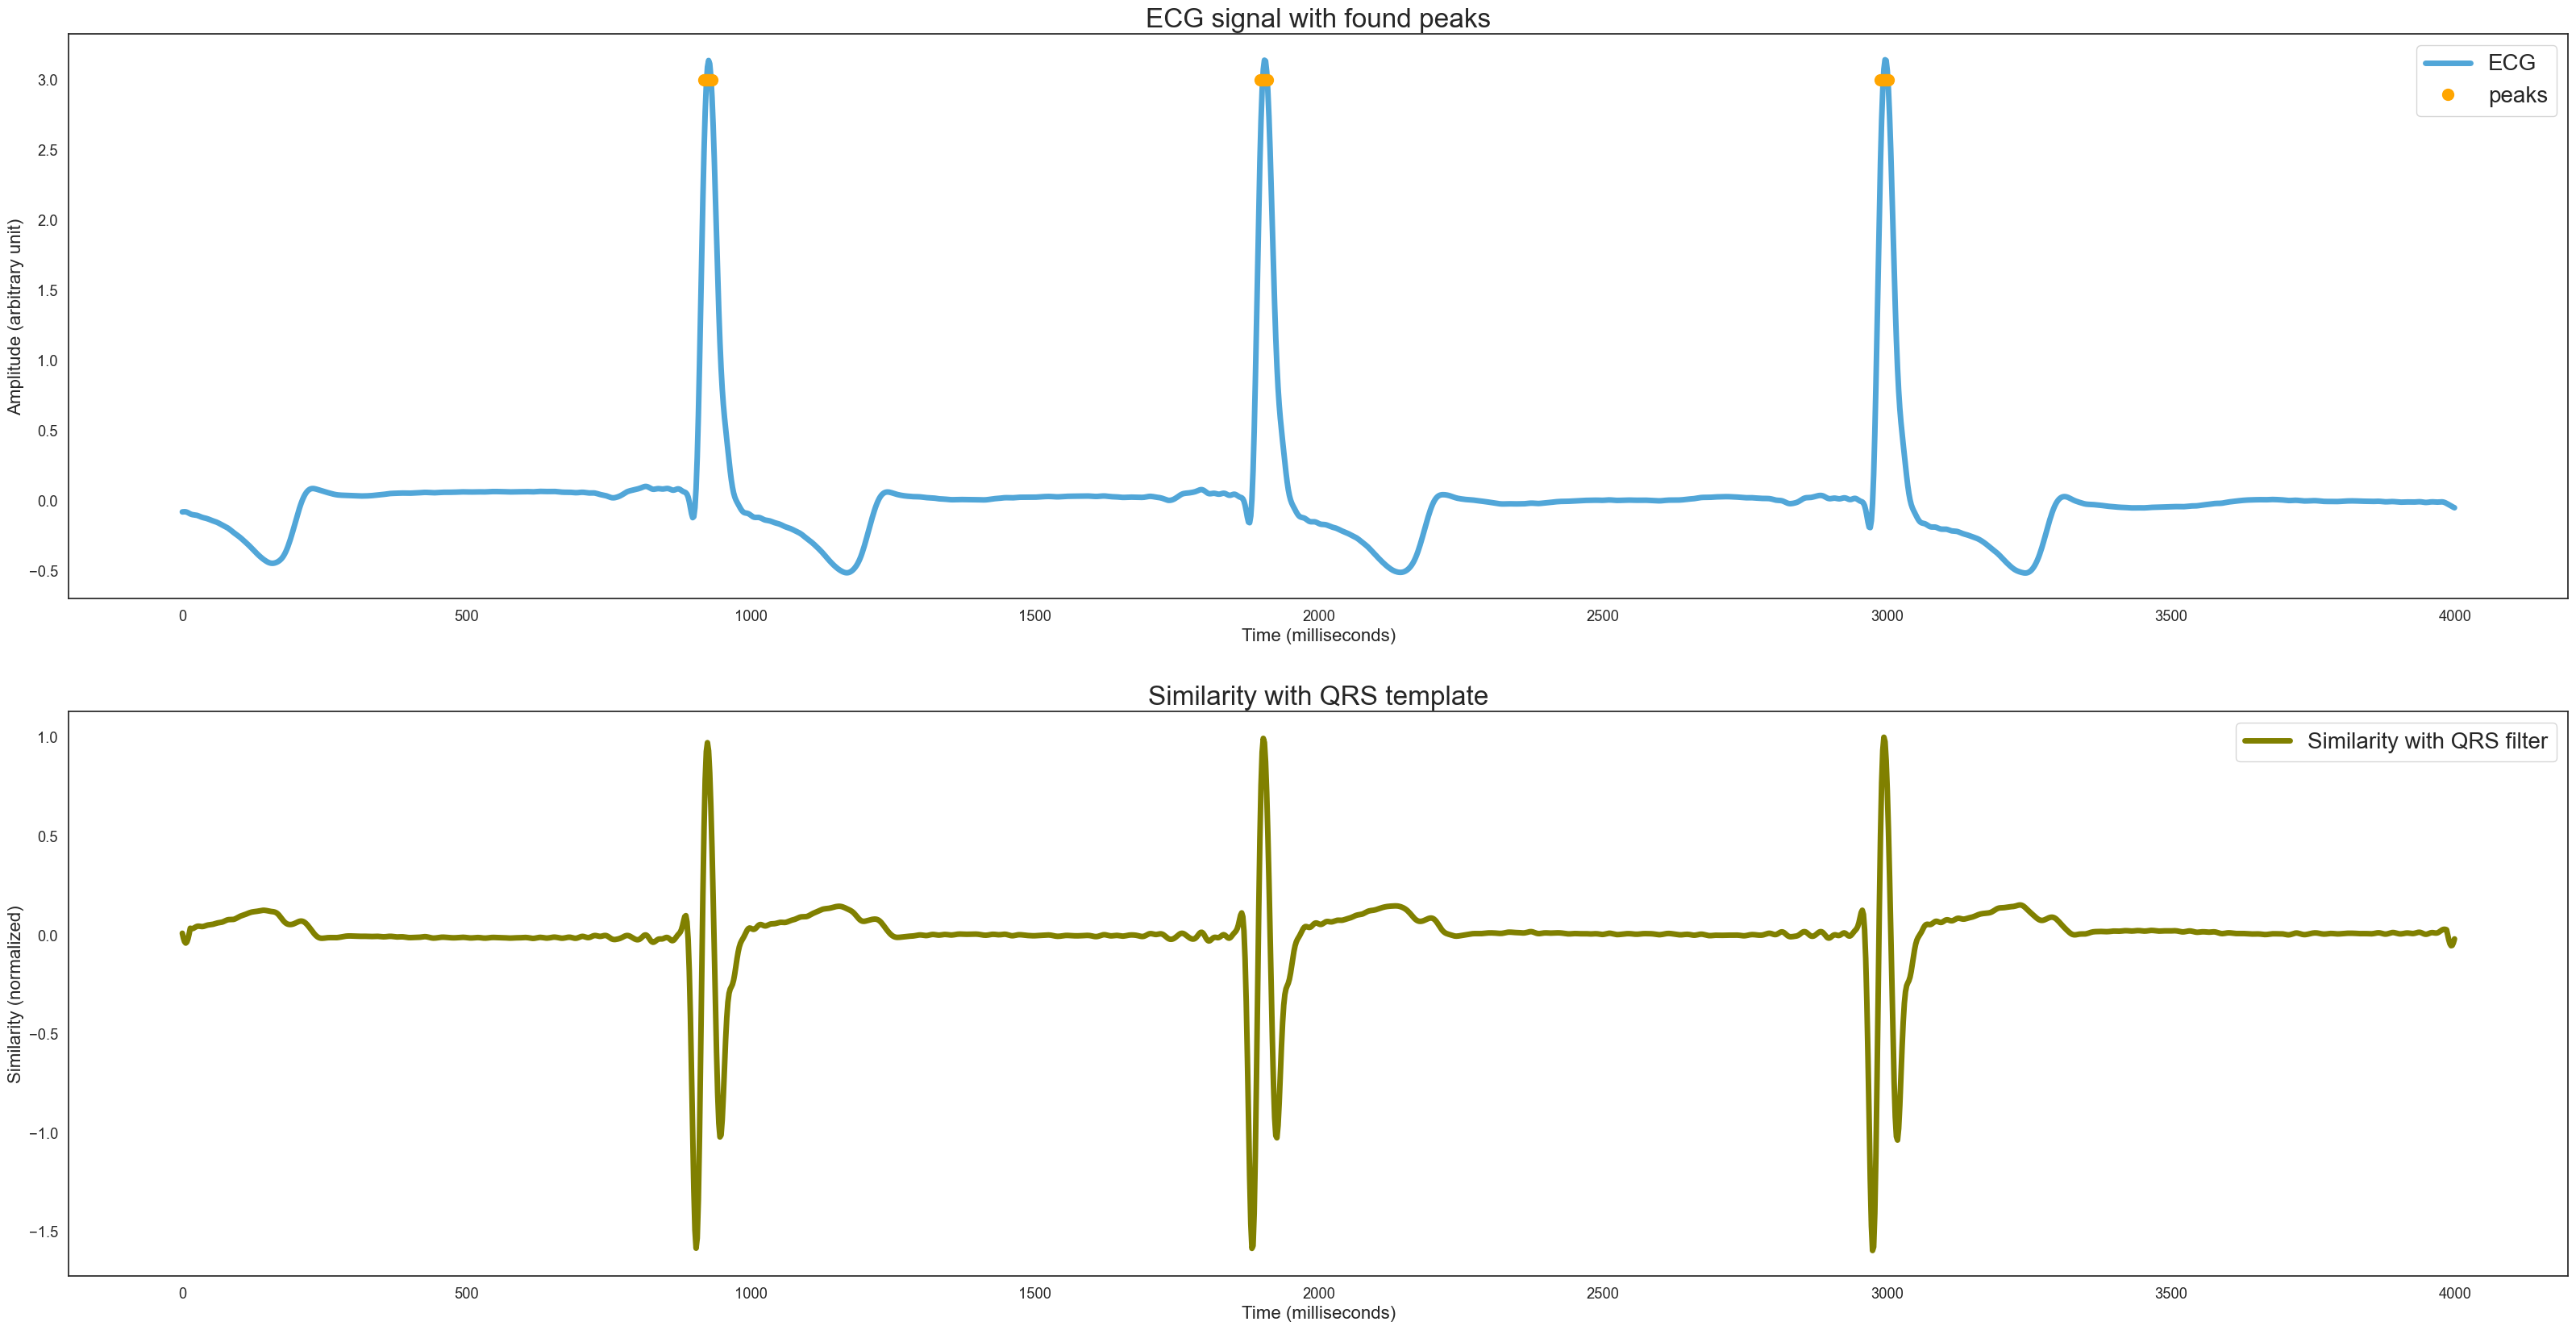

In [109]:
# R-R detection

start = 0
ecg_slice = features[0]
times_x = np.arange(start, 4000, 2)
# detect peaks
peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)

# plot similarity
plt.figure(figsize=(40, 20))

plt.subplot(211)
plt.title("ECG signal with found peaks", fontsize=24)
plt.plot(times_x, ecg_slice, label="ECG", color="#51A6D8", linewidth=5)
plt.plot(peaks*2, np.repeat(3, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (milliseconds)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

plt.subplot(212)
plt.title('Similarity with QRS template', fontsize=24)
plt.plot(times_x, similarity, label="Similarity with QRS filter", color="olive", linewidth=5)
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (milliseconds)", fontsize=16)
plt.ylabel("Similarity (normalized)", fontsize=16)

Text(0, 0.5, 'Amplitude (arbitrary unit)')

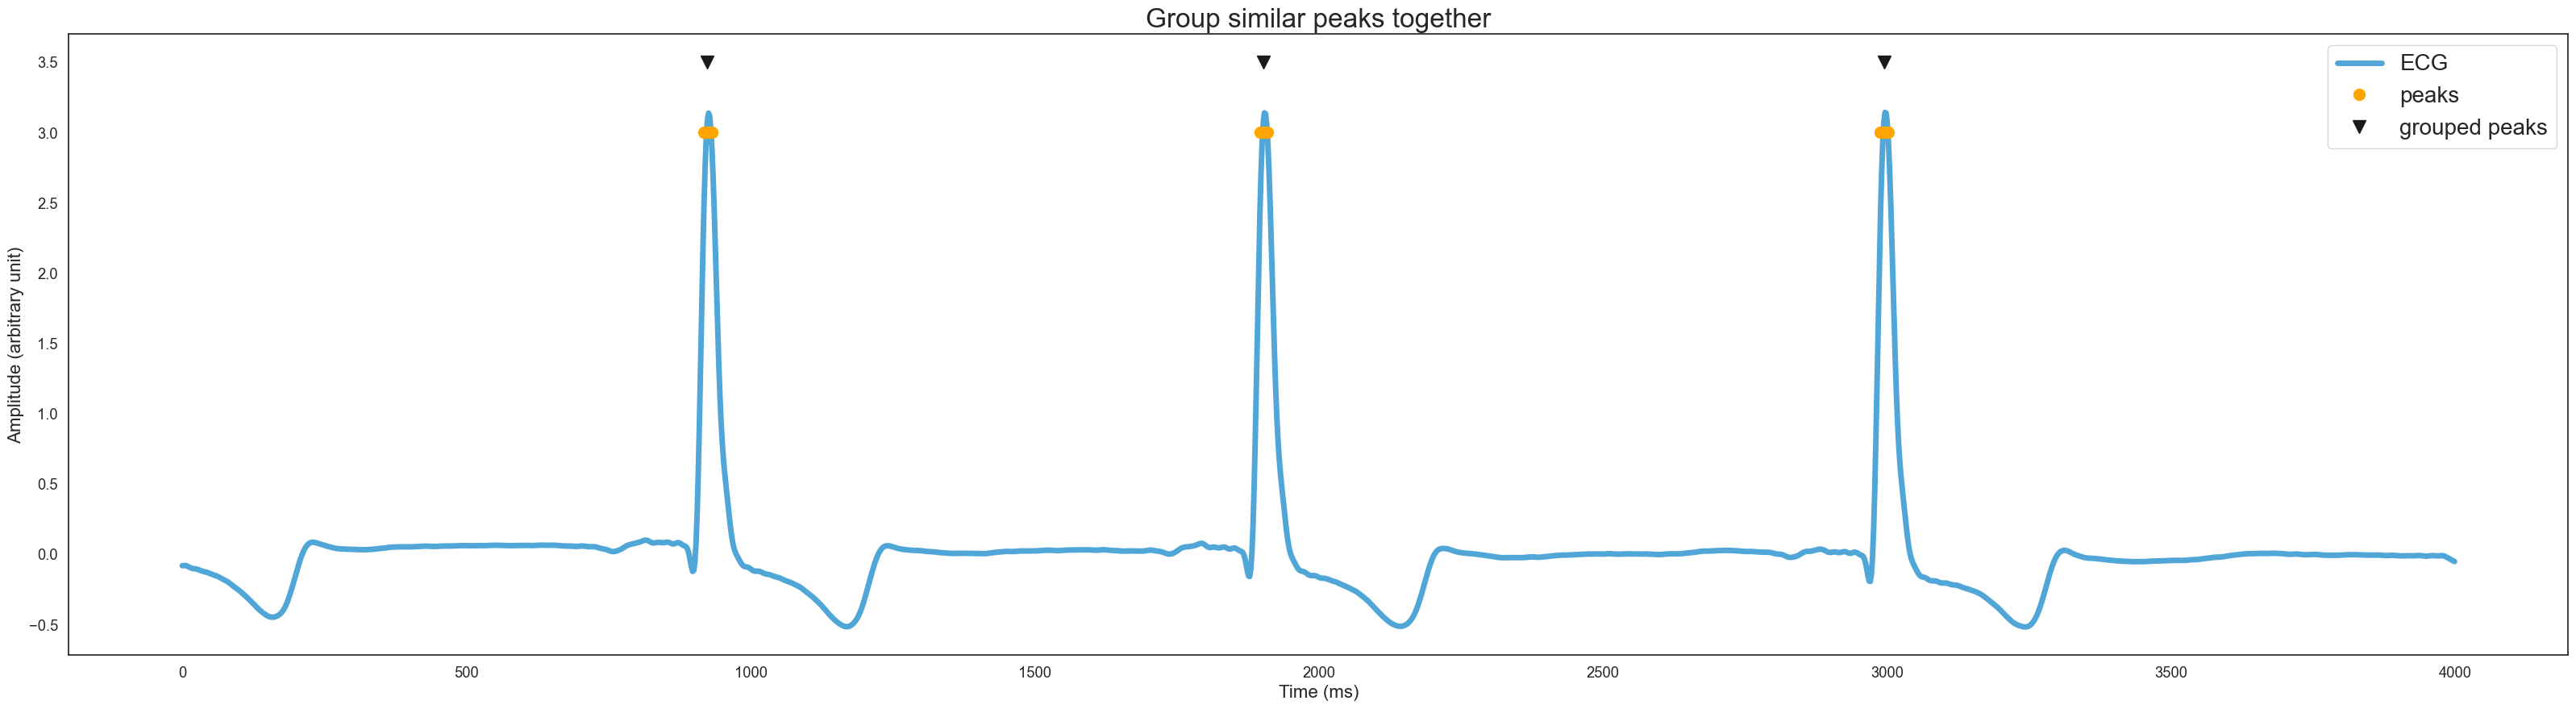

In [110]:
# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(40, 10))
plt.title("Group similar peaks together", fontsize=24)
plt.plot(times_x, ecg_slice, label="ECG", color="#51A6D8", linewidth=5)
plt.plot(peaks*2, np.repeat(3, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks*2, np.repeat(3.5, grouped_peaks.shape[0]), markersize=12, label="grouped peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right", fontsize=20)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

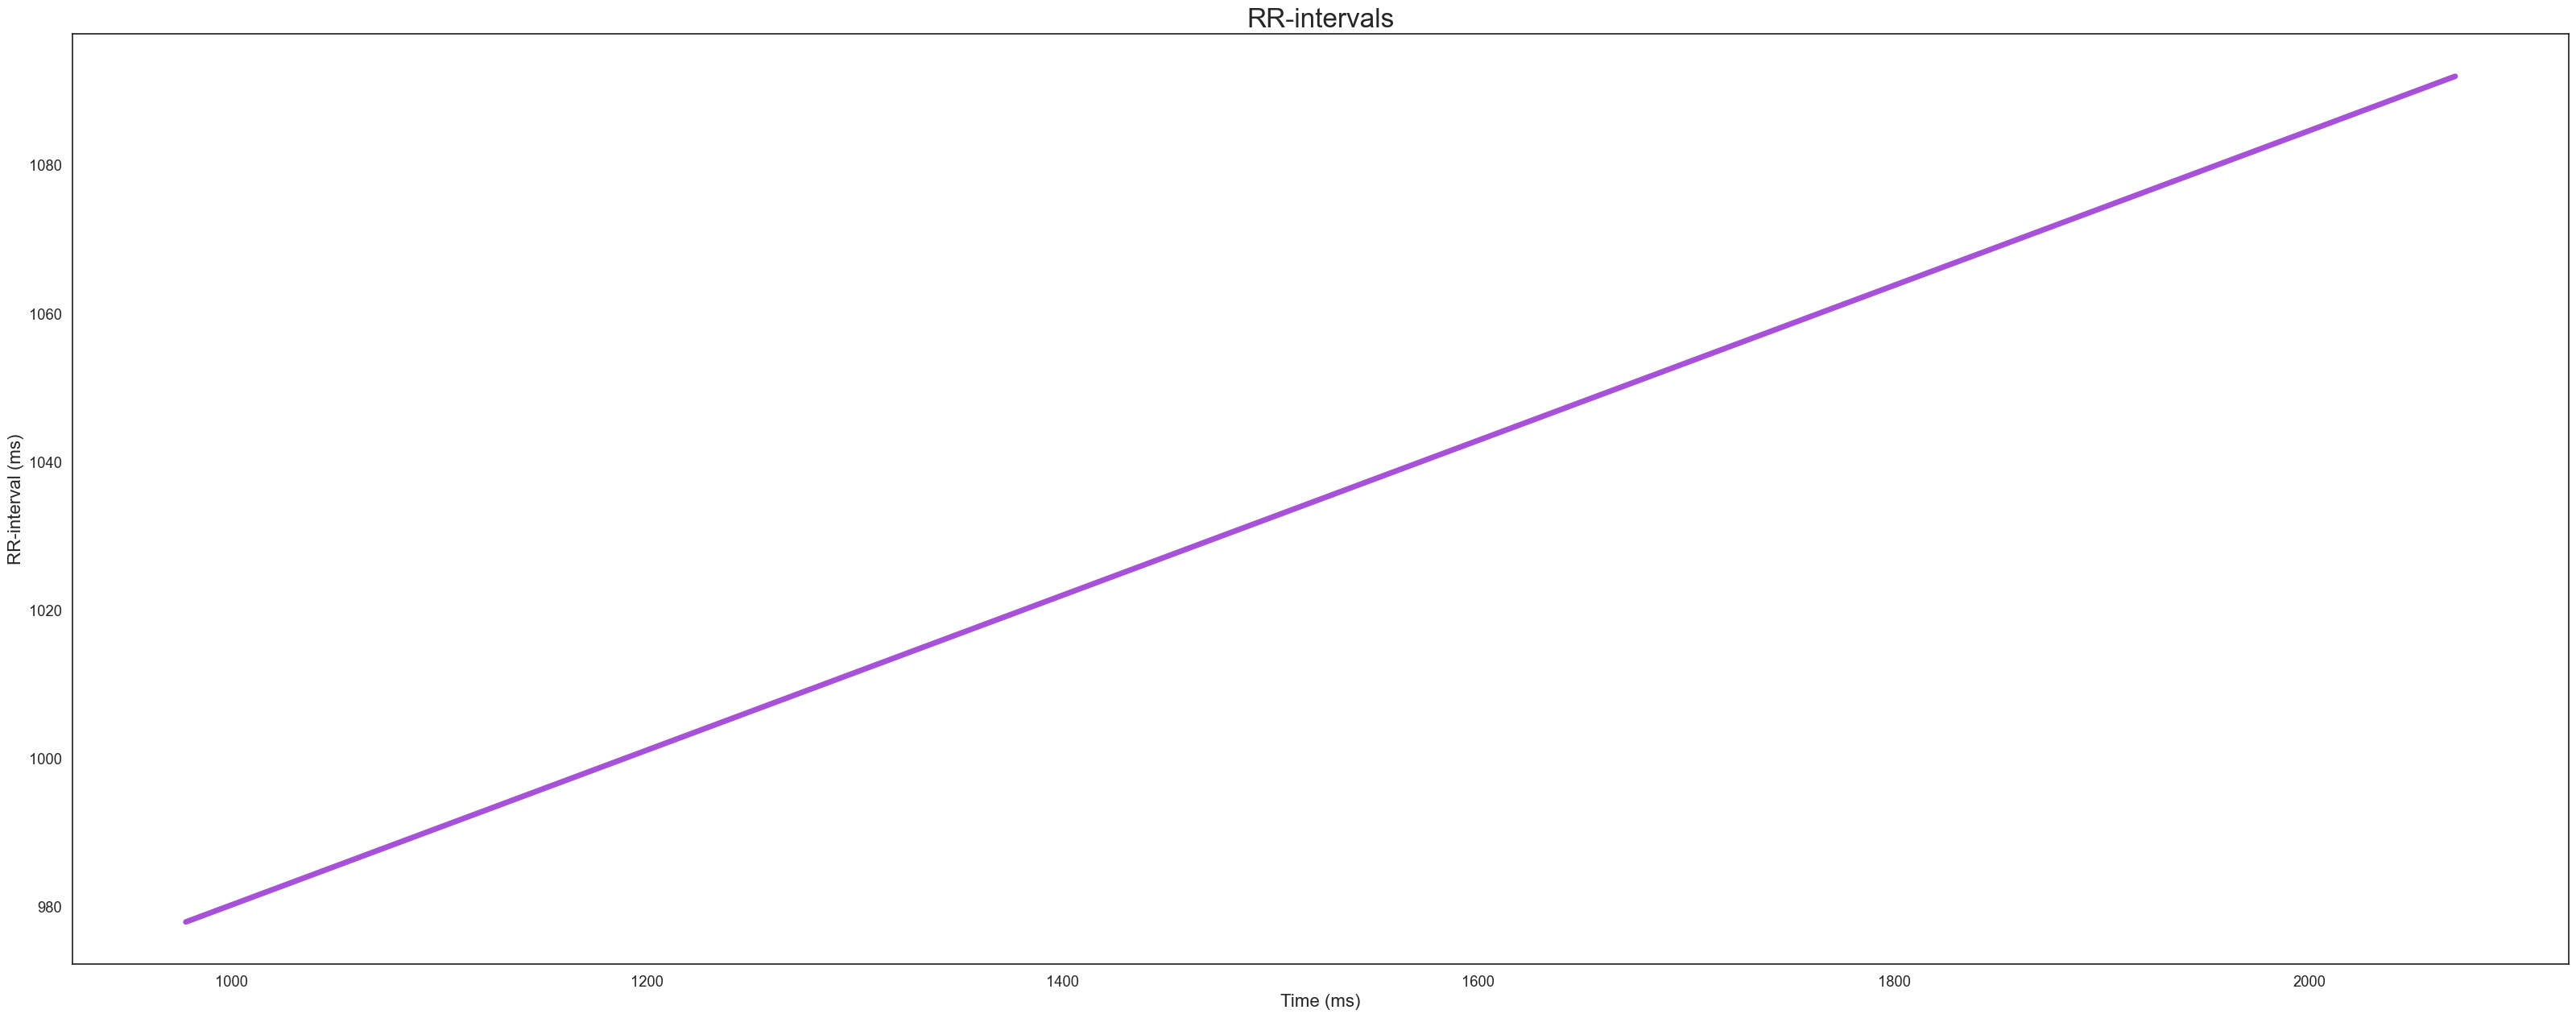

In [112]:
# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks*2)

# plot RR-intervals
plt.figure(figsize=(40, 15))
plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8", linewidth=5)

/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_33190/387997369.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)


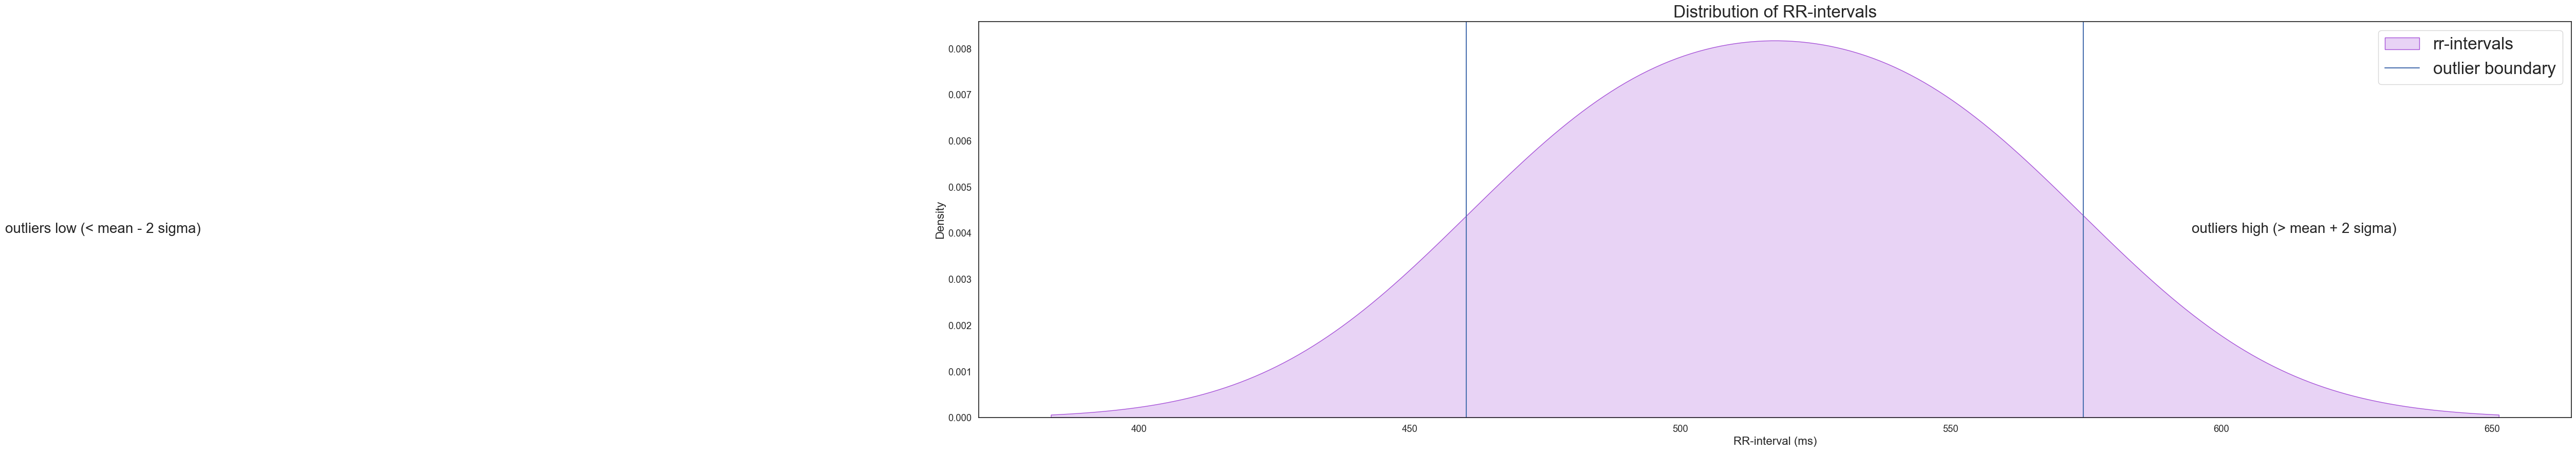

In [105]:
plt.figure(figsize=(40, 10))
plt.title("Distribution of RR-intervals", fontsize=24)
sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr)-2 * np.std(rr)
outlier_high = np.mean(rr)+2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

plt.xlabel("RR-interval (ms)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(fontsize=24)

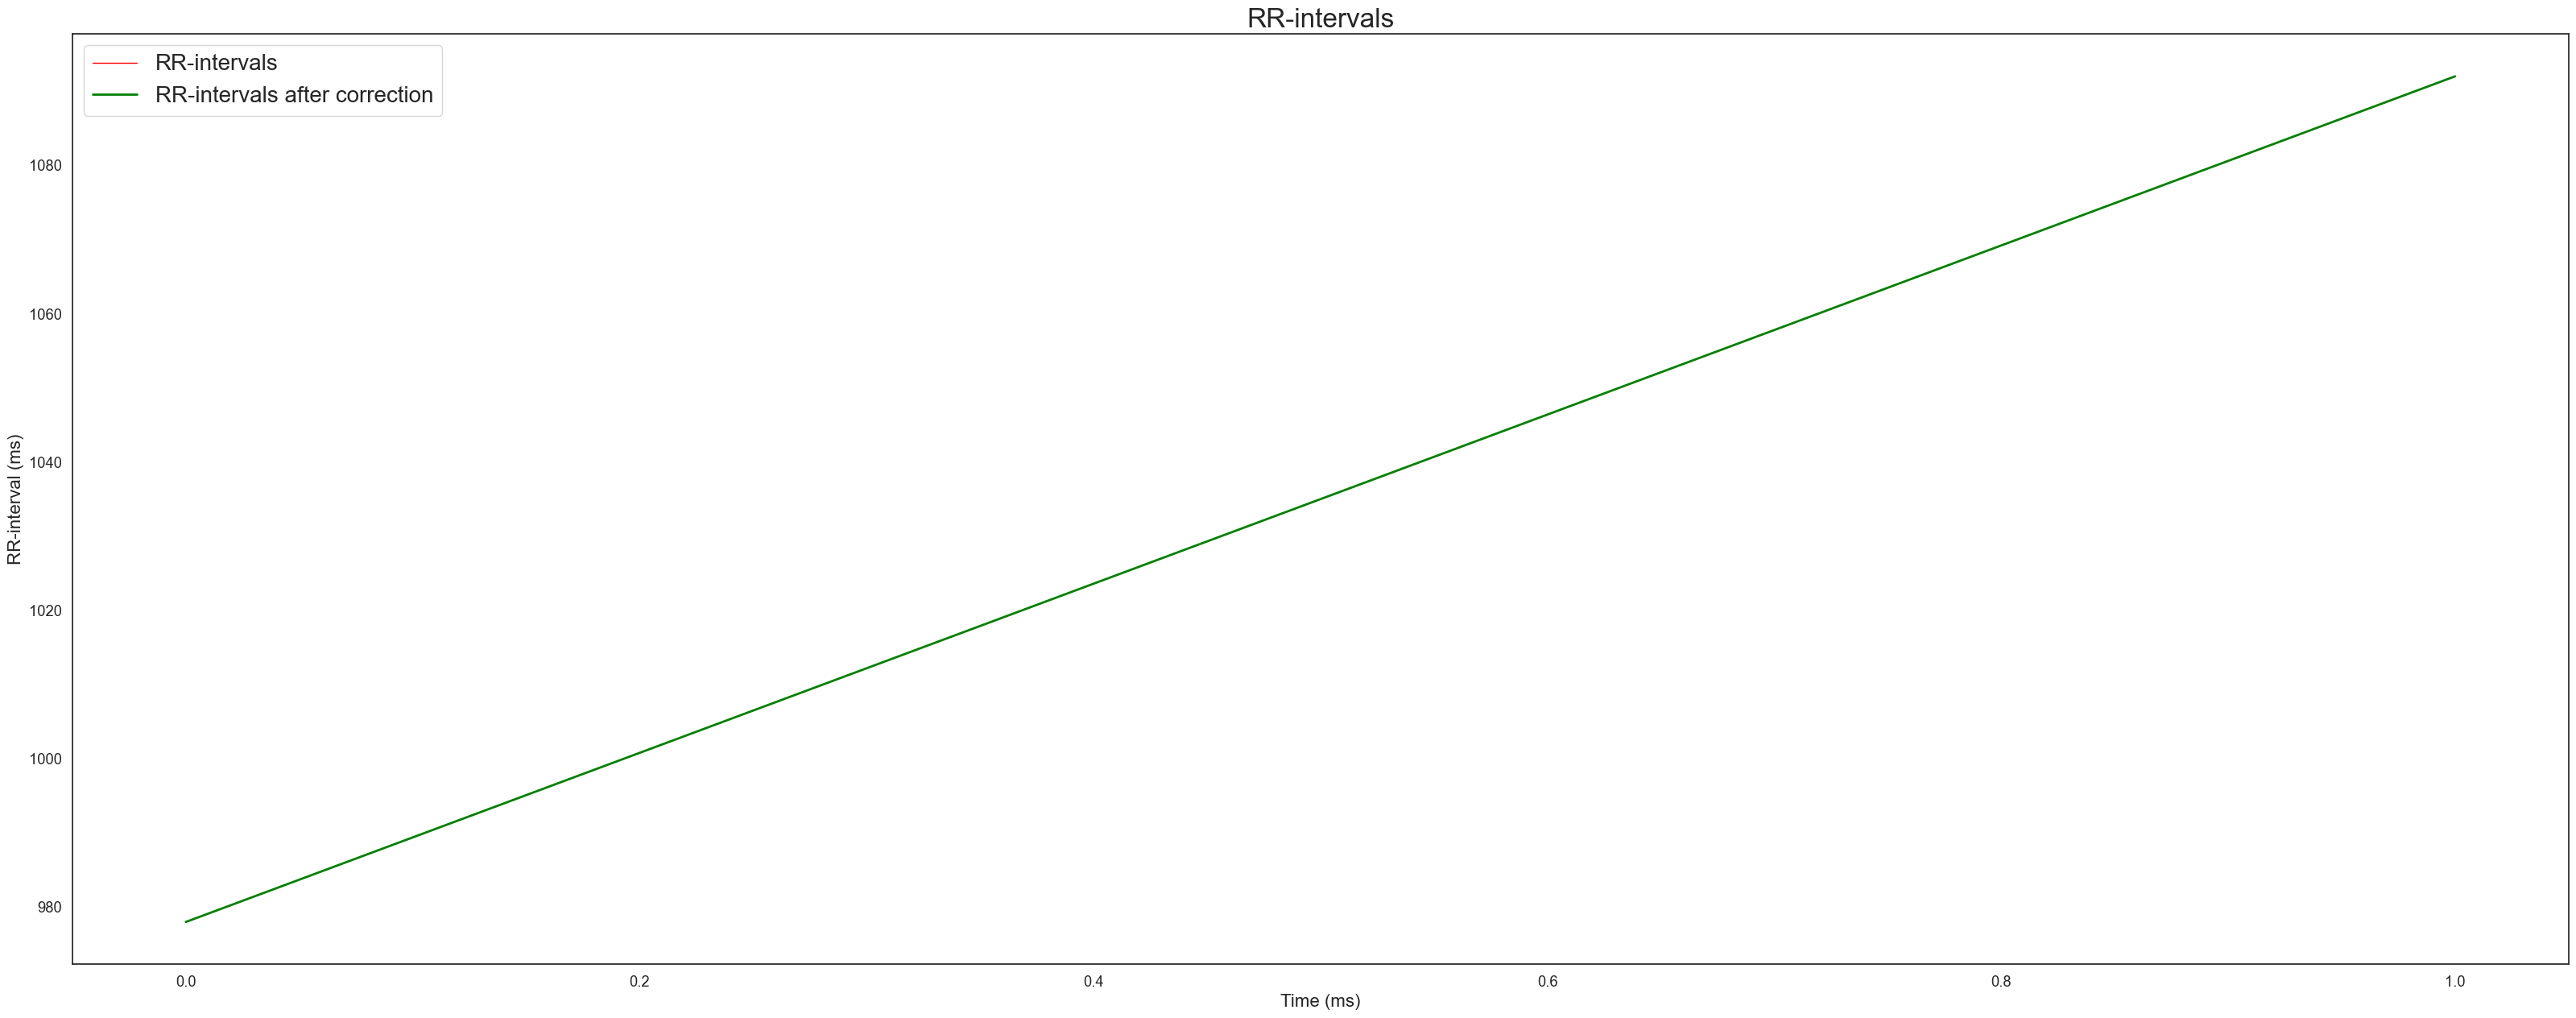

In [113]:
plt.figure(figsize=(40, 15))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)

### Plot frequency bandpower - EEG

In [3]:
# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
    print('Person dictionary')

Person dictionary


In [ ]:
n_rows = 4 # four blocks
num_trial = 2
num_slices = num_trial*5
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=num_slices,
    figsize=(num_slices * 4, n_rows * 3),
    sharey="row",
    sharex=True,
)

for idx, ax in enumerate(axes.flat):
    no_row = int(idx/num_slices)
    no_col = int(idx%num_slices)
    i = 65*no_row+no_col
    sns.lineplot(marker_features[0]['C']['DELTA'][i], ax=ax)
    ax.set_title(f'trial {int(no_col/5)+1}')
#marker_features[0]['C']['DELTA'].shape 260/4 = 65 slices per block = 65/13 = 5 slices per trial

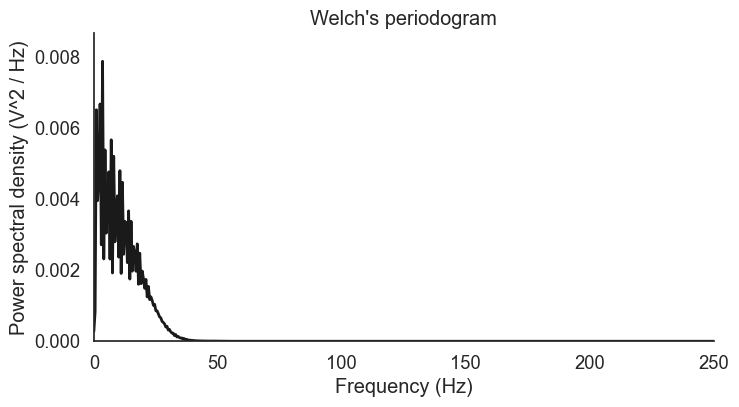

In [126]:
"""
Reference: https://raphaelvallat.com/bandpower.html
"""
# Define window length (4 seconds)
data = all_data['audio_hvha'].get_all_data()[marker]
sf = all_data['audio_hvha'].get_srate(marker)
win = 2 * sf
freqs, psd = signal.welch(data[0, :, 3], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style="white")
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color="k", lw=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (V^2 / Hz)")
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

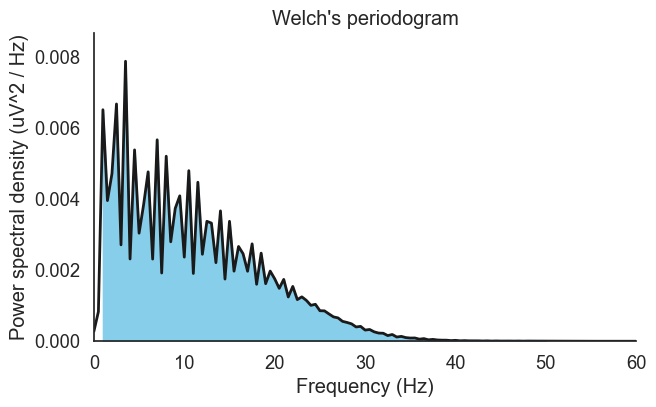

In [127]:
# Define lower and upper limits
low, high = 1, 50 #EEG_BANDS[Feature.GAMMA]

# Find intersecting values in frequency vector
idx_psd = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color="k")
plt.fill_between(freqs, psd, where=idx_psd, color="skyblue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (uV^2 / Hz)")
plt.xlim([0, 60])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_psd], dx=freq_res)
print(f"Absolute {BAND.name} power: %.3f uV^2" % delta_power)